# Time-Series Forecasting on the S&P500 Index

For this project, we are traders at the S&P500 futures desk. We are interested in building a model to predict the trading of the S&P500 index so we can provide effective futures. We are going to work with a dataset from Yahoo Finance called yahoo_stock.csv. We are going to make use of a RNN network structure to predict the index using the dataset as training data.

## Data Wrangling and Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
stock = pd.read_csv("yahoo_stock.csv")

In [3]:
stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [4]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [5]:
stock.shape

(1825, 7)

In [6]:
stock.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [7]:
stock.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


We used the read_csv method from pandas to load in the dataset into a pandas dataframe. The dataset consists of 1825 entries and 7 columns: 6 columns have float64 datatype and 1 column (date) has object datatype. There are no missing values. The statistical analysis shows that there are likely no odd values (such as zero volume trading). However, there is a likelihood for an upperbound outlier in terms of most quantitative variables. Only the volume variables shows a mean larger than the median (indicating left skewness).

Next we are going to make sure there are in fact no missing values, no large outliers and the data is sorted by the date column.

In [8]:
for c in stock.columns:
    if stock[c].isnull().sum().item() != 0:
        print(f"Column {c} contains missing values")
else:
    print("No missing values detected in the entire dataset")

No missing values detected in the entire dataset


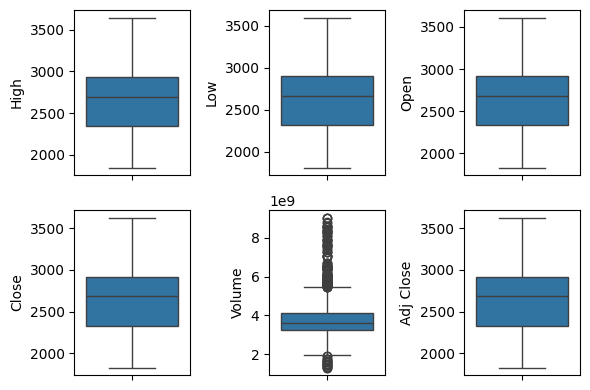

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4))
axes = axes.flatten()

for i, c in enumerate(stock.columns[1:]):
    sns.boxplot(data=stock, y=c, ax=axes[i])

plt.tight_layout()

Upon closer inspection, it appears that the volume variables shows the presence of significant outliers. All the other variables do not indicate outliers.

In order to verify the outliers, we are going to make use of the $ 1.5 \times IQR $ method.

In [10]:
stats = stock["Volume"].describe()
IQR = stats["75%"] - stats["25%"]
upper_bound = stats["75%"] + 1.5 * IQR
lower_bound = stats["25%"] - 1.5 * IQR

print(f"Upper bound is {upper_bound:.2e} and lower bound is {lower_bound:.2e}")

Upper bound is 5.47e+09 and lower bound is 1.93e+09


The IQR method reveals that the upper bound is around 5.5e09 and the lower bound around 1.9e09. Next we are going to take a look how many entries exceed these bounds.

In [11]:
stock.loc[stock["Volume"] > upper_bound].shape[0]

139

In [12]:
stock.loc[stock["Volume"] < lower_bound].shape[0]

23

There are only 139 cases where the upper bound is exceeded and only 23 cases where the lower bound is not met. In order to really decided whether or not to remove this data. We are going to visualize the boxplot again in isolation.

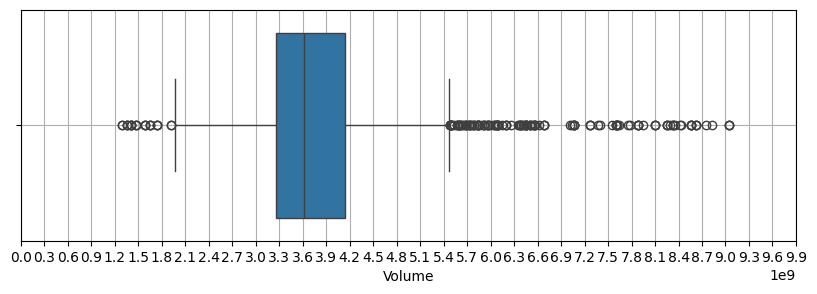

In [13]:
plt.figure(figsize=(10, 3))
sns.boxplot(data=stock, x="Volume")
plt.xticks(np.arange(0, 10e09, step=3e08))
plt.grid();

Reviewing this new visualization, we are going to decide to remove the upper bound outliers that are larger than 6.9e09 in volume. This represents a unique and isolated group of outliers that could be considered as major outliers.

In [14]:
stock.loc[stock["Volume"] > 6.9e09].shape[0]

51

This amounts to removing 51 datapoints in total. After removal, we should be left with 1774 entries and the max volume not exceeding 6.9e09. Let's now remove the outliers.

In [15]:
stock_update = stock.loc[stock["Volume"] < 6.9e09]

In [16]:
stock_update.shape

(1774, 7)

In [17]:
stock_update["Volume"].describe()

count    1.774000e+03
mean     3.751387e+09
std      8.405979e+08
min      1.296540e+09
25%      3.251602e+09
50%      3.580460e+09
75%      4.051708e+09
max      6.683070e+09
Name: Volume, dtype: float64

The outliers are successfully removed.

Next we are going to sort the remaining data by the date column. In order to do this we have to convert the date datatype from object to the datetime object datatype. We can do this with the built-in pandas method.

In [18]:
stock_date = stock_update.copy()
stock_date["Date"] = pd.to_datetime(stock_date["Date"])

In [19]:
stock_date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1774 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1774 non-null   datetime64[ns]
 1   High       1774 non-null   float64       
 2   Low        1774 non-null   float64       
 3   Open       1774 non-null   float64       
 4   Close      1774 non-null   float64       
 5   Volume     1774 non-null   float64       
 6   Adj Close  1774 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 110.9 KB


In [20]:
stock_date.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [21]:
stock_date.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1820,2020-11-16,3628.510010,3600.159912,3600.159912,3626.909912,5.281980e+09,3626.909912
1821,2020-11-17,3623.110107,3588.679932,3610.310059,3609.530029,4.799570e+09,3609.530029
1822,2020-11-18,3619.090088,3567.330078,3612.090088,3567.790039,5.274450e+09,3567.790039
1823,2020-11-19,3585.219971,3543.840088,3559.409912,3581.870117,4.347200e+09,3581.870117
1824,2020-11-20,3581.229980,3556.850098,3579.310059,3557.540039,2.236662e+09,3557.540039


Now that we converted our date to a datetime object, it does appear as if the dataframe is already sorted by date. We will force the sorting to make sure that the dataframe is sorted and then make the sorted dataframe rely on the date column as the index.

In [22]:
sorted_stock = stock_date.sort_values(by="Date").set_index("Date")

In [23]:
sorted_stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


Now we have a sorted dataframe and the data entries are the index of the dataframe. We have confirmed there are no missing values and we have removed major outliers from the volume columns by removing entire rows.

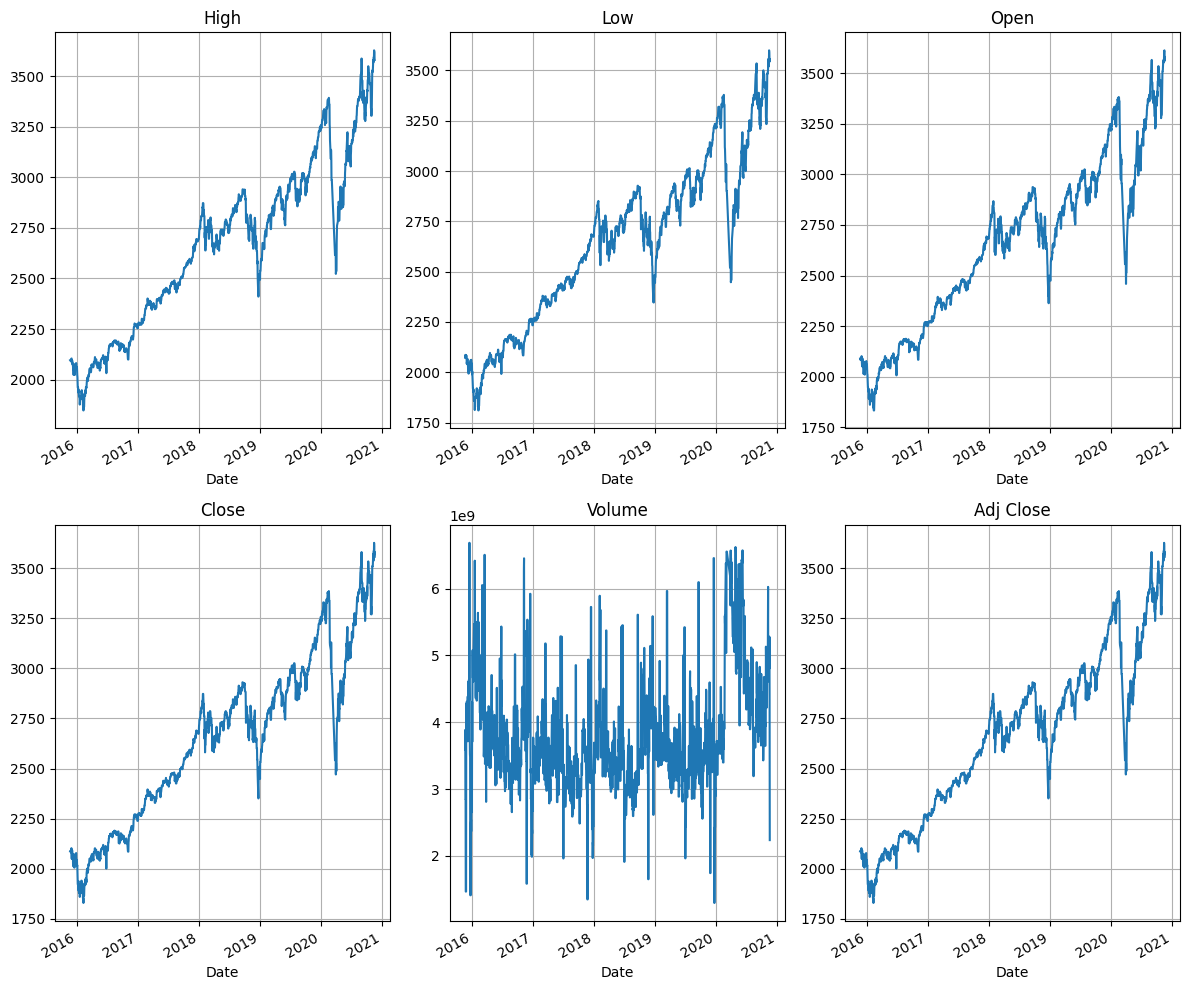

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
axes = axes.flatten()

for i, c in enumerate(sorted_stock.columns):
    sorted_stock[c].plot(ax=axes[i])
    axes[i].grid()
    axes[i].set_title(c)

plt.tight_layout()

The volume data appears to be rather noisy and the remaining data is very similar trend-wise. We are going to focus on the adjusted close of the S&P500 index since these values are already adjusted for dividends. We will drop the rest of the columns and work with the smaller dataset.

In [31]:
stock_adj = sorted_stock[["Adj Close"]]

In [32]:
stock_adj.shape

(1774, 1)

Unfortunately, we have now removed data from the volume column that we are no longer using. It would be better for the model to have access to all data especially because the adj close column did not exhibit large outliers to begin with.

We are now going to perform the above steps again to generate our final dataset to perform data preparation on (scaling, training etc).

In [44]:
stock_adj = stock[["Date", "Adj Close"]]
stock_final = stock_adj.copy()
stock_final["Date"] = pd.to_datetime(stock_adj["Date"])
stock_final = stock_final.sort_values(by="Date").set_index("Date")

In [45]:
stock_final.head()

,Adj Close
Date,
2015-11-23,2086.590088
2015-11-24,2089.139893
2015-11-25,2088.870117
2015-11-26,2088.870117
2015-11-27,2090.110107


In [46]:
stock_final.shape

(1825, 1)

We now have our final dataset and we will continue with the data preparation stage.

## Data Preprocessing

First we are going to split our data into training, validation and testing. Since this is time series data, we will split the data along the time axis (not randomly). We are going to use a 60-20-20 split.

In [48]:
print(f"Size of training set is {stock_final.shape[0] * 0.60}")
print(f"Size of validation and test set is {stock_final.shape[0] * 0.20}")

Size of training set is 1095.0
Size of validation and test set is 365.0


This split will give us 1 year of validation and test set and 3 years of training data.

In [53]:
stock_train = stock_final.iloc[:1095, :]
stock_val = stock_final.iloc[1095:(1095 + 365), :]
stock_test = stock_final.iloc[(1095 + 365):, :]

In [54]:
print(stock_train.shape, stock_val.shape, stock_test.shape)

(1095, 1) (365, 1) (365, 1)


Next we are going to use a scaler to scale down the adj close values to be between 0 and 1 (scale the min to zero and max to 1).

In [55]:
from sklearn.preprocessing import MinMaxScaler

In [70]:
scaler = MinMaxScaler()
scaler.fit(stock_train)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [71]:
train_scaled = pd.DataFrame(
    data=scaler.transform(stock_train), 
    columns=stock_train.columns, 
    index=stock_train.index
)

In [72]:
train_scaled.head()

,Adj Close
Date,
2015-11-23,0.233745
2015-11-24,0.236060
2015-11-25,0.235815
2015-11-26,0.235815
2015-11-27,0.236940


In [73]:
train_scaled.describe()

,Adj Close
count,1095.000000
mean,0.526525
std,0.264593
min,0.000000
25%,0.292420
50%,0.520337
75%,0.772278
max,1.000000


In [74]:
val_scaled = pd.DataFrame(
    data=scaler.transform(stock_val),
    columns=stock_val.columns,
    index=stock_val.index
)

test_scaled = pd.DataFrame(
    data=scaler.transform(stock_test),
    columns=stock_test.columns,
    index=stock_test.index
)

In [75]:
val_scaled.head()

,Adj Close
Date,
2018-11-22,0.745096
2018-11-23,0.729329
2018-11-24,0.729329
2018-11-25,0.729329
2018-11-26,0.766445


In [76]:
test_scaled.head()

,Adj Close
Date,
2019-11-22,1.162971
2019-11-23,1.162971
2019-11-24,1.162971
2019-11-25,1.184166
2019-11-26,1.190411


In [77]:
val_scaled.describe()

,Adj Close
count,365.000000
mean,0.927363
std,0.142335
min,0.473844
25%,0.845162
50%,0.960042
75%,1.035873
max,1.173627


In [78]:
test_scaled.describe()

,Adj Close
count,365.000000
mean,1.209132
std,0.247662
min,0.370637
25%,1.084590
50%,1.266849
75%,1.379796
max,1.631913


Now we have split our data and scaled the data between 0 and 1. The training data is nicely scaled to this range and the validation data and test data are scaled according to the training distribution. We are now going to create our window technique to produce our X and y variables for the RNN system to begin forecasting.

In [79]:
def create_dataset(dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        window = dataset.iloc[i:(window_size + i), 0]
        target = dataset.iloc[(i + window_size), 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

In [80]:
window_size = 10

In [91]:
X_train, y_train = create_dataset(train_scaled, window_size)
X_val, y_val = create_dataset(val_scaled, window_size)
X_test, y_test = create_dataset(test_scaled, window_size)

In [92]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

We have now converted our time series data into packages of features and targets by simply splitting our data with a specified window size. We then converted the data into numpy arrays and reshaped them to make the shape compatible with our next step.

## Build and Train a Basic RNN Model

Now that we created our training, validation and test datasets, we are going to build and train a basic RNN model to perform the time series forecasting of the S&P500 index.

We will use the tensorflow library to begin building our model.

In [93]:
from tensorflow import keras
from tensorflow.keras import layers

In [97]:
rnn_model = keras.Sequential(
    [
        keras.Input(shape=(1, window_size)),
        layers.SimpleRNN(10, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(1)
    ]
)

In [99]:
rnn_model.compile(optimizer="adam", loss="mean_squared_error")

In [101]:
rnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

We have now constructed a simple rnn model using the adam optimizer and MSE loss function. We are now going to train this model using our training data and using the validation data to get a sense of the performance. The performance metric will be the r2_score from the sklearn package.

In [102]:
rnn_model.fit(X_train, y_train)

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5875


In [103]:
y_pred = rnn_model.predict(X_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [104]:
from sklearn.metrics import r2_score

In [105]:
r2_score(y_val, y_pred)

-51.95778060855141

We can tell from the r2 score that our current simple RNN model does not in fact predict our S&P500 index very well. We need further optimizations to improve the accuracy of the model.

## Build and Train an LSTM Model

We are going to replace the simplernn layer in our previous model with the lstm layer and verify the new performance.

In [106]:
lstm_model = keras.Sequential(
    [
        keras.Input(shape=(1, window_size)),
        layers.LSTM(10, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(1)
    ]
)

In [107]:
lstm_model.compile(optimizer="adam", loss="mean_squared_error")

In [108]:
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10)                  │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
lstm_model.fit(X_train, y_train)

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2571


In [110]:
y_pred = lstm_model.predict(X_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [111]:
lstm_score = r2_score(y_val, y_pred)
lstm_score

-20.11582197075571

We notice that replacing the simplernn with the lstm layer significantly improved the overall r2-score (the result increased from -52 to -20). The score itself is still not very good and further improvements are needed to consider this model for future predictions.

## Add a Convolutional Layer

Next we are going to explore the additional of a convolutional layer to our LSTM model to see how this inclusion may improve the performance.

In [116]:
lstm_conv = keras.Sequential(
    [
        keras.Input(shape=(1, window_size)),
        layers.Conv1D(64, 1, activation="relu"),
        layers.MaxPool1D(1),
        layers.LSTM(10, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(1)
    ]
)

In [117]:
lstm_conv.compile(optimizer="adam", loss="mean_squared_error")

In [118]:
lstm_conv.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 1, 64)               │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 10)                  │           3,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,825 (14.94 KB)

 Trainable params: 3,825 (14.94 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
lstm_conv.fit(X_train, y_train)

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.2573


In [120]:
y_pred = lstm_conv.predict(X_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [121]:
conv_score = r2_score(y_val, y_pred)
conv_score

-18.032457873615154

The score was further optimized to -18. This improvement is even smaller than the inclusion of the LSTM layer. More improvements are needed to make a succesful predictive model.

## Optimize the Model

We are now going to focus on further improvements of the model. We are going to consider the following aspects:
- Window size
- Number of hidden layers
- Number of nodes per layer
- Type of recurrent layer
- Inclusion or not of a convolutional layer
- Activation function
- Optimizer
- Loss function
- Number of epochs

We are initially going to focus on the hidden layers and nodes and removing the convolutional layer using LSTM as the recurrent layer.

In [122]:
new_model = keras.Sequential(
    [
        keras.Input(shape=(1, window_size)),
        layers.LSTM(10, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ]
)

In [123]:
new_model.compile(optimizer="adam", loss="mean_squared_error")

In [124]:
new_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 10)                  │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,169 (16.29 KB)

 Trainable params: 4,169 (16.29 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
new_model.fit(X_train, y_train)

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2472


In [126]:
y_pred = new_model.predict(X_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [127]:
new_score = r2_score(y_val, y_pred)
new_score

-15.822032870764762

Adding the additional hidden layers and removing the convolutional layer slightly improved the model. We are now going to focus on the window size instead.

In [186]:
new_window = 5

In [187]:
X_train, y_train = create_dataset(train_scaled, new_window)
X_val, y_val = create_dataset(val_scaled, new_window)
X_test, y_test = create_dataset(test_scaled, new_window)

In [188]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [199]:
newer_model = keras.Sequential(
    [
        keras.Input(shape=(1, new_window)),
        layers.LSTM(10, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ]
)

In [200]:
newer_model.compile(optimizer="adam", loss="mean_squared_error")

In [201]:
newer_model.fit(X_train, y_train, epochs=35)

Epoch 1/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1048
Epoch 2/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124
Epoch 3/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9706e-04
Epoch 4/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8408e-04
Epoch 5/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4992e-04
Epoch 6/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6366e-04
Epoch 7/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5907e-04
Epoch 8/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5593e-04
Epoch 9/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6590e-04
Epoch 10/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2184e-04
Epoch 11/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.9088e-04
Epoch 12/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7067e-04
Epoch 13/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.9500e-04
Epoch 14/35
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.6192e-04
Epoch 15/35
35/35 ━━━━━━━━━━━━━

In [202]:
y_pred = newer_model.predict(X_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


In [203]:
newer_score = r2_score(y_val, y_pred)
newer_score

0.9784228225194362

Dropping the window_size from 10 to 5 and adding another hidden layer with 128 nodes and increasing the training epochs to 35 made a tremendous improvement on the accuracy which moved from -15 to 0.98 on the validation set!

## Evaluate Model Performance

We are now going to use the newer_model to make predictions for the training, validation and testing data.

In [204]:
train_pred = newer_model.predict(X_train)
val_pred = newer_model.predict(X_val)
test_pred = newer_model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [207]:
training_score = r2_score(y_train, train_pred)
val_score = r2_score(y_val, val_pred)
test_score = r2_score(y_test, test_pred)

In [208]:
print(f"Training score: {training_score:.4f}")
print(f"Validation score: {val_score:.4f}")
print(f"Testing score: {test_score:.4f}")

Training score: 0.9970
Validation score: 0.9784
Testing score: 0.9635


The r2 score of the test data compared to the validation data does seem to indicate a slight loss of accuracy, which could potentially hint at training data overfitting. However, this loss in accuracy seems to be rather slim.

We are now going to unscale the predicted datasets.

In [210]:
train_pred = scaler.inverse_transform(train_pred)
val_pred = scaler.inverse_transform(val_pred)
test_pred = scaler.inverse_transform(test_pred)

Next we are going to un-window the data so we can plot the data!

In [211]:
plot_train_pred = np.empty((len(stock_final), 1))
plot_train_pred[:] = np.nan
plot_train_pred[new_window:len(train_pred) + new_window, :] = train_pred

plot_val_pred = np.empty((len(stock_final), 1))
plot_val_pred[:] = np.nan
plot_val_pred[
    len(train_pred) + (new_window * 2) + 1:len(train_pred) + len(val_pred) + (new_window * 2) + 1,
    :
] = val_pred

plot_test_pred = np.empty((len(stock_final), 1))
plot_test_pred[:] = np.nan
plot_test_pred[len(train_pred) + len(val_pred) + (new_window * 3) + 2:len(stock_final) - 1, :] = test_pred

Now we are going to plot the unscaled and unwindowed training, validation and test data on top of the original dataset.

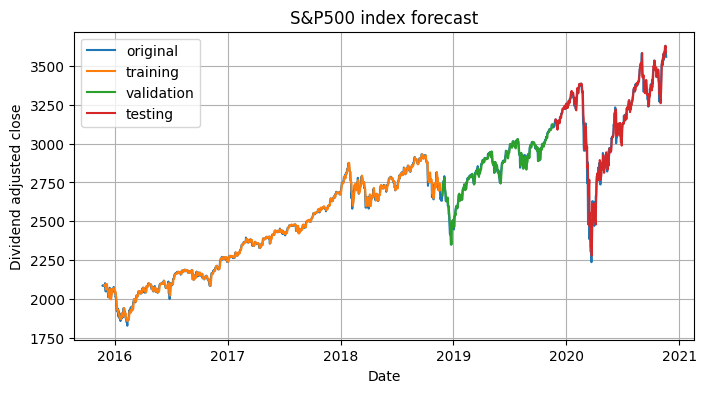

In [221]:
plt.figure(figsize=(8, 4))
plt.plot(stock_final.index, stock_final["Adj Close"], label="original")
plt.plot(stock_final.index, plot_train_pred, label="training")
plt.plot(stock_final.index, plot_val_pred, label="validation")
plt.plot(stock_final.index, plot_test_pred, label="testing")
plt.xlabel("Date")
plt.ylabel("Dividend adjusted close")
plt.title("S&P500 index forecast")
plt.legend()
plt.grid();

The predictions for the S&P500 index looks as good as the r2_score suggested it would look. We can see some instances where the original data deviates from the training, validation or test data. The general trend, however, matches quite nicely with the original data.